# Gradient Boosting Machines (GBMs) with XGBoost


![](https://i.imgur.com/6MYc56a.png)


Let's begin by installing the required libraries.

In [ ]:
!pip install numpy pandas matplotlib seaborn --quiet

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 68 kB 3.1 MB/s 
     |████████████████████████████████| 193.6 MB 25 kB/s 
     |████████████████████████████████| 47 kB 3.1 MB/s 
     |████████████████████████████████| 2.0 MB 36.9 MB/s 
     |████████████████████████████████| 9.7 MB 35.1 MB/s 


## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data


In [ ]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

Let's load the data into Pandas dataframes.

In [ ]:
ross_df = pd.read_csv('train.csv',low_memory=False)
store_df = pd.read_csv('store.csv')

## EDA

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [ ]:
df_eda = ross_df.copy().reset_index(drop=True)
df_eda = df_eda[df_eda["Open"] == 1].reset_index(drop=True)
split_date(df_eda)
df_eda.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31


In [ ]:
import plotly.express as px

In [ ]:
axis = df_eda.groupby('Month')[['Sales']].mean()
fig = px.line(axis, x = axis.index, y = 'Sales', title = 'Promedio de ventas por mes', markers = True)
fig.show()

In [ ]:
axis = df_eda.groupby('Day')[['Sales']].mean()
fig = px.line(axis, x = axis.index, y = 'Sales', title = 'Promedio de ventas por día', markers = True)
fig.show()

In [ ]:
axis = df_eda.groupby('DayOfWeek')[['Sales']].mean()
fig = px.line(axis, x = axis.index, y = 'Sales', title = 'Venta promedio por día de semana', markers = True)
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

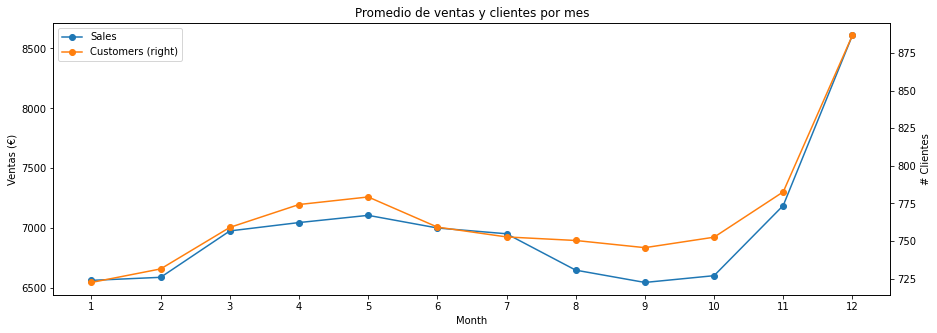

In [ ]:
ax = df_eda.groupby('Month')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15,5), marker='o')
ax.set_ylabel('Ventas (€)')
ax.right_ax.set_ylabel('# Clientes')
ax.set_xticks(range(1,13))
plt.title('Promedio de ventas y clientes por mes');

In [ ]:
#https://www.kaggle.com/code/ashishpatel26/rossman-stores-sales-analysis
#https://www.kaggle.com/code/jefersonyehuda/eda-prediction-with-prophet
#https://www.kaggle.com/code/arcticai/rossmann-sales-analysis-with-facebook-prophet

In [ ]:
#Cuantas tiendas hay?
df_eda.Store.nunique()
print(f"Hay {df_eda.Store.nunique()} tiendas")

Hay 1115 tiendas


In [ ]:
# Fecha minima y maxima de las tiendas
df_store_date = df_eda.groupby('Store').agg({
                                              'Date': ['count','min','max']}).reset_index()

df_store_date.columns = ['Store','cantidad','minimo','maximo']
df_store_date['d_dias'] = df_store_date['maximo'] - df_store_date['minimo']
df_store_date = df_store_date.sort_values(by = 'cantidad', ascending = False)                                         
#df_store.rename(columns={'Sales': 'avg_Sales',
#                         'Customers' : 'avg_Customers'}, inplace=True)
#df_store['Store'] = df_store['Store'].astype(str) 
print(df_store_date.describe(include='all'))
df_store_date.head(15)

             Store     cantidad               minimo               maximo  \
count   1115.00000  1115.000000                 1115                 1115   
unique         NaN          NaN                    5                    3   
top            NaN          NaN  2013-01-02 00:00:00  2015-07-31 00:00:00   
freq           NaN          NaN                 1094                 1113   
first          NaN          NaN  2013-01-01 00:00:00  2015-07-10 00:00:00   
last           NaN          NaN  2013-07-05 00:00:00  2015-07-31 00:00:00   
mean     558.00000   757.302242                  NaN                  NaN   
std      322.01708    63.861126                  NaN                  NaN   
min        1.00000   592.000000                  NaN                  NaN   
25%      279.50000   776.000000                  NaN                  NaN   
50%      558.00000   779.000000                  NaN                  NaN   
75%      836.50000   782.000000                  NaN                  NaN   

<ipython-input-15-c47d2c8a03db>:11: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Store,cantidad,minimo,maximo,d_dias
768,769,942,2013-01-01,2015-07-31,941 days
1096,1097,942,2013-01-01,2015-07-31,941 days
84,85,942,2013-01-01,2015-07-31,941 days
561,562,942,2013-01-01,2015-07-31,941 days
261,262,942,2013-01-01,2015-07-31,941 days
732,733,942,2013-01-01,2015-07-31,941 days
493,494,942,2013-01-01,2015-07-31,941 days
681,682,942,2013-01-01,2015-07-31,941 days
334,335,942,2013-01-01,2015-07-31,941 days
422,423,942,2013-01-01,2015-07-31,941 days


In [ ]:
#Revisar cuantos clientes y ventas en promedio tiene cada tienda y cual es la mas alta
df_store = df_eda.groupby('Store').agg({'Sales': 'mean',
                                        'Customers': 'mean'}).sort_values(by='Sales', ascending=False).reset_index()
df_store['avg_customer_sales'] = df_store['Sales']/df_store['Customers']
df_store.rename(columns={'Sales': 'avg_Sales',
                         'Customers' : 'avg_Customers'}, inplace=True)
df_store['Store'] = df_store['Store'].astype(str) 
df_store.head(15)

,Store,avg_Sales,avg_Customers,avg_customer_sales
0,817,21757.483418,3130.573980,6.949998
1,262,20718.515924,3402.010616,6.090080
2,1114,20666.562500,3200.946429,6.456391
3,251,19123.068036,2450.492940,7.803764
4,842,18574.795820,1149.242765,16.162639
5,513,18179.089286,2096.335459,8.671842
6,562,17969.556263,3105.053079,5.787198
7,788,17961.914541,1717.901786,10.455728
8,383,17294.716667,2205.447436,7.841818
9,756,16574.816431,2346.572529,7.063415


In [ ]:
def grafico_store(tabla,variable,title):
  plt.figure(figsize=(10,6))
  plt.title(title)
  temp = tabla.sort_values(by=variable, ascending=False)
  sns.barplot(data=temp.head(5), x=variable, y='Store', 
    color='#69b3a2')

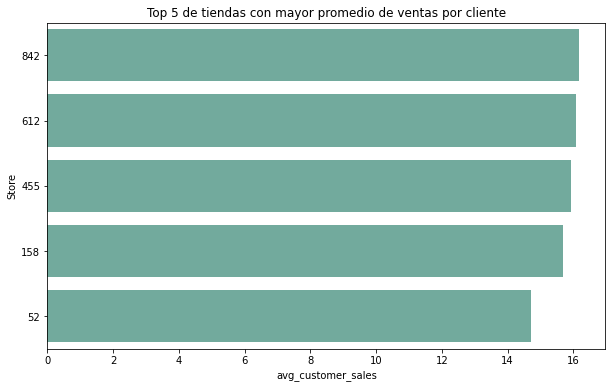

In [ ]:
grafico_store(df_store,'avg_customer_sales','Top 5 de tiendas con mayor promedio de ventas por cliente')

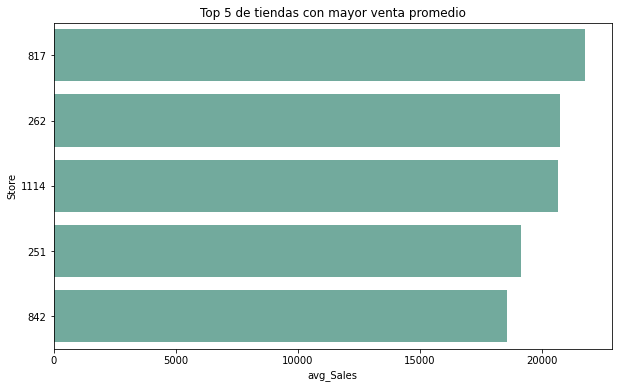

In [ ]:
grafico_store(df_store,'avg_Sales','Top 5 de tiendas con mayor venta promedio')

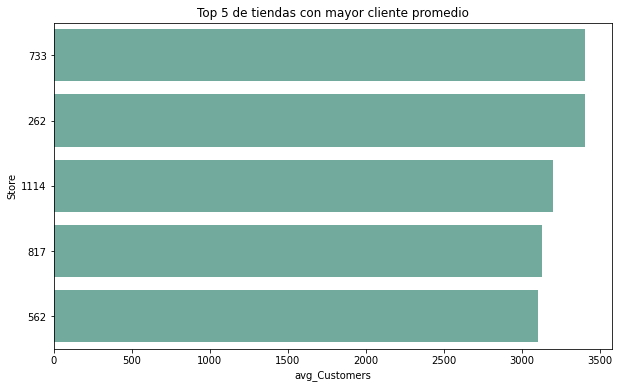

In [ ]:
grafico_store(df_store,'avg_Customers','Top 5 de tiendas con mayor cliente promedio')

In [ ]:
import random

random.seed(1992)

data = ross_df.sample(frac=0.90)
data_unseen = ross_df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

# print the revised shape
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (915488, 9)
Unseen Data For Predictions: (101721, 9)


In [ ]:
ross_df = data

In [ ]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,555,4,2015-01-29,4939,410,1,1,0,0
1,156,1,2014-03-10,4944,627,1,0,0,0
2,73,2,2015-07-21,4081,463,1,0,0,1
3,265,5,2014-09-19,5046,529,1,1,0,0
4,97,2,2014-11-11,7050,692,1,1,0,0
...,...,...,...,...,...,...,...,...,...
915483,310,4,2013-01-10,9258,792,1,1,0,0
915484,358,4,2013-03-14,7090,905,1,0,0,0
915485,361,1,2014-09-15,7572,678,1,1,0,0
915486,1077,3,2014-10-01,5591,529,1,1,0,0


In [ ]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [ ]:
merged_df = ross_df.merge(store_df, how='left', on='Store')

In [ ]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,555,4,2015-01-29,4939,410,1,1,0,0,d,a,1560.0,1.0,2014.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec"
1,156,1,2014-03-10,4944,627,1,0,0,0,a,a,2020.0,2.0,2011.0,1,14.0,2011.0,"Mar,Jun,Sept,Dec"
2,73,2,2015-07-21,4081,463,1,0,0,1,a,c,1650.0,9.0,2008.0,0,NaN,NaN,NaN
3,265,5,2014-09-19,5046,529,1,1,0,0,a,a,4580.0,NaN,NaN,1,14.0,2015.0,"Jan,Apr,Jul,Oct"
4,97,2,2014-11-11,7050,692,1,1,0,0,d,c,8980.0,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915483,310,4,2013-01-10,9258,792,1,1,0,0,a,c,2290.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
915484,358,4,2013-03-14,7090,905,1,0,0,0,a,a,2890.0,10.0,2003.0,0,NaN,NaN,NaN
915485,361,1,2014-09-15,7572,678,1,1,0,0,c,c,4490.0,5.0,2014.0,1,5.0,2013.0,"Feb,May,Aug,Nov"
915486,1077,3,2014-10-01,5591,529,1,1,0,0,a,a,3750.0,11.0,2001.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec"


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915488 entries, 0 to 915487
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      915488 non-null  int64  
 1   DayOfWeek                  915488 non-null  int64  
 2   Date                       915488 non-null  object 
 3   Sales                      915488 non-null  int64  
 4   Customers                  915488 non-null  int64  
 5   Open                       915488 non-null  int64  
 6   Promo                      915488 non-null  int64  
 7   StateHoliday               915488 non-null  object 
 8   SchoolHoliday              915488 non-null  int64  
 9   StoreType                  915488 non-null  object 
 10  Assortment                 915488 non-null  object 
 11  CompetitionDistance        913128 non-null  float64
 12  CompetitionOpenSinceMonth  624504 non-null  float64
 13  CompetitionOpenSinceYear   62


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [ ]:
split_date(merged_df)

In [ ]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,555,4,2015-01-29,4939,410,1,1,0,0,d,a,1560.0,1.0,2014.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec",2015,1,29,5
1,156,1,2014-03-10,4944,627,1,0,0,0,a,a,2020.0,2.0,2011.0,1,14.0,2011.0,"Mar,Jun,Sept,Dec",2014,3,10,11
2,73,2,2015-07-21,4081,463,1,0,0,1,a,c,1650.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,21,30
3,265,5,2014-09-19,5046,529,1,1,0,0,a,a,4580.0,NaN,NaN,1,14.0,2015.0,"Jan,Apr,Jul,Oct",2014,9,19,38
4,97,2,2014-11-11,7050,692,1,1,0,0,d,c,8980.0,NaN,NaN,0,NaN,NaN,NaN,2014,11,11,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915483,310,4,2013-01-10,9258,792,1,1,0,0,a,c,2290.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2013,1,10,2
915484,358,4,2013-03-14,7090,905,1,0,0,0,a,a,2890.0,10.0,2003.0,0,NaN,NaN,NaN,2013,3,14,11
915485,361,1,2014-09-15,7572,678,1,1,0,0,c,c,4490.0,5.0,2014.0,1,5.0,2013.0,"Feb,May,Aug,Nov",2014,9,15,38
915486,1077,3,2014-10-01,5591,529,1,1,0,0,a,a,3750.0,11.0,2001.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec",2014,10,1,40


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [33]:
merged_df[merged_df["Open"] == 0]["Sales"].value_counts()

0    155520
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [34]:
merged_df = merged_df[merged_df["Open"] == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [35]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [36]:
comp_months(merged_df)

In [37]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,555,4,2015-01-29,4939,410,1,1,0,0,d,a,1560.0,1.0,2014.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec",2015,1,29,5,12.0
1,156,1,2014-03-10,4944,627,1,0,0,0,a,a,2020.0,2.0,2011.0,1,14.0,2011.0,"Mar,Jun,Sept,Dec",2014,3,10,11,37.0
2,73,2,2015-07-21,4081,463,1,0,0,1,a,c,1650.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,21,30,82.0
3,265,5,2014-09-19,5046,529,1,1,0,0,a,a,4580.0,NaN,NaN,1,14.0,2015.0,"Jan,Apr,Jul,Oct",2014,9,19,38,0.0
4,97,2,2014-11-11,7050,692,1,1,0,0,d,c,8980.0,NaN,NaN,0,NaN,NaN,NaN,2014,11,11,46,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915483,310,4,2013-01-10,9258,792,1,1,0,0,a,c,2290.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2013,1,10,2,0.0
915484,358,4,2013-03-14,7090,905,1,0,0,0,a,a,2890.0,10.0,2003.0,0,NaN,NaN,NaN,2013,3,14,11,113.0
915485,361,1,2014-09-15,7572,678,1,1,0,0,c,c,4490.0,5.0,2014.0,1,5.0,2013.0,"Feb,May,Aug,Nov",2014,9,15,38,4.0
915486,1077,3,2014-10-01,5591,529,1,1,0,0,a,a,3750.0,11.0,2001.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec",2014,10,1,40,155.0


Let's view the results of the new columns we've created.

In [38]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
739906,2015-04-21,2240.0,2013.0,5.0,23.0
17319,2014-01-04,900.0,2010.0,9.0,40.0
293043,2014-12-17,1910.0,2013.0,7.0,17.0
789918,2013-05-24,90.0,2014.0,6.0,0.0
821974,2015-04-20,360.0,2014.0,3.0,13.0
439327,2014-05-15,830.0,NaN,NaN,0.0
126200,2015-07-08,1420.0,NaN,NaN,0.0
121112,2013-06-29,940.0,2004.0,4.0,110.0
877675,2015-04-30,2330.0,NaN,NaN,0.0
588262,2014-03-01,8980.0,NaN,NaN,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [39]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [40]:
promo_cols(merged_df)

Let's view the results of the columns we've created.

In [42]:
merged_df[['Store','Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Store,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
700821,679,2014-04-05,0,NaN,NaN,NaN,0.000000,0
777377,376,2014-07-02,0,NaN,NaN,NaN,0.000000,0
627209,615,2014-07-30,0,NaN,NaN,NaN,0.000000,0
226252,869,2014-07-01,1,2011.0,14.0,"Jan,Apr,Jul,Oct",38.983607,1
684835,611,2013-09-09,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
15639,1064,2015-03-23,0,NaN,NaN,NaN,0.000000,0
869565,607,2013-09-03,1,2011.0,14.0,"Jan,Apr,Jul,Oct",29.049180,0
182016,504,2014-07-19,0,NaN,NaN,NaN,0.000000,0
379885,351,2014-11-22,1,2013.0,5.0,"Feb,May,Aug,Nov",21.639344,1
547389,1054,2013-11-13,1,2013.0,45.0,"Feb,May,Aug,Nov",0.229508,1


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [43]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [44]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [45]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [46]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [47]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    1956
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [48]:
max_distance = inputs.CompetitionDistance.max()


In [49]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

In [50]:
max_distance

75860.0

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [53]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [54]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [56]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [57]:
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [58]:
X = inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

In [59]:
X.columns

Index(['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month', 'Day',
       'Month', 'Year', 'WeekOfYear', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c'],
      dtype='object')

## Modeling

In [65]:
from xgboost import XGBRegressor

In [62]:
#numeric_cols

['Store',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpen',
 'Promo2',
 'Promo2Open',
 'IsPromo2Month',
 'Day',
 'Month',
 'Year',
 'WeekOfYear']

In [66]:
X = inputs[numeric_cols + encoded_cols]

In [67]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [68]:
%%time
model.fit(X, targets)

CPU times: user 1h 4min 30s, sys: 5.6 s, total: 1h 4min 35s
Wall time: 33min 31s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [84]:
len(preds)

759968

In [76]:
preds = model.predict(X)

AttributeError: ignored

In [79]:
print(preds[0:3]), print(targets[0:3])

[4974.4795 5322.711  4061.8445]
0    4939
1    4944
2    4081
Name: Sales, dtype: int64


(None, None)

In [80]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [81]:
rmse(preds, targets)

373.98889125454895

In [73]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [74]:
importance_df#.head(10)

,feature,importance
24,StoreType_b,0.289698
1,Promo,0.082493
18,DayOfWeek_7,0.071669
5,Promo2,0.058083
3,CompetitionDistance,0.050979
27,Assortment_a,0.049546
0,Store,0.049129
23,StoreType_a,0.036914
29,Assortment_c,0.036817
12,DayOfWeek_1,0.034026


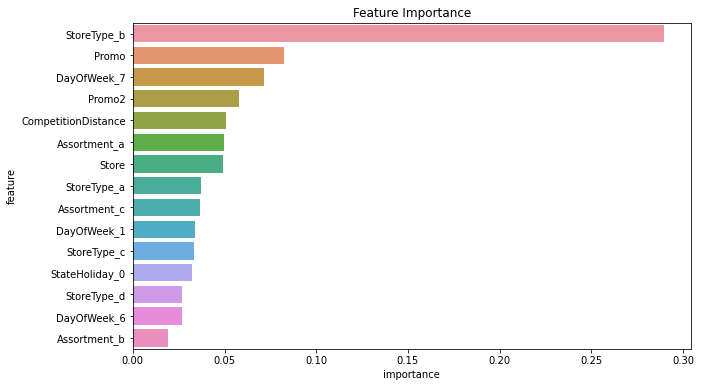

In [75]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');

In [72]:
import joblib

#pickle

model_filename = 'model.pkl'
joblib.dump(model, model_filename)

import pickle

# Lets dump our rf_model
pickle.dump(scaler, open('scaler_model.pkl','wb'))
pickle.dump(encoder, open('encoder.pkl','wb'))



#joblib.dump(scaler, 'scaler_model.pkl')
#joblib.dump(encoder, 'encoder.pkl')


print("Modelo grabado!")

Modelo grabado!


In [ ]:
#identificar las variables que entran
#guardar los onehotencoder
#guardar los scaler

In [ ]:
import sklearn

In [ ]:
import xgboost

In [ ]:
#versiones
print(np.__version__)
print(pd.__version__)
print(xgboost.__version__)
print(sklearn.__version__)


1.21.6
1.3.5
1.6.2
1.0.2
